---
**Introduction to Numerical Shooting**

Week 15 of EMAT30008

https://engmaths.github.io/emat30008/odes/numericalshooting/ 

(See week15funcs.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.optimize import root
from typing import Literal

# Move to parent directory, then w14, import, change back
# TODO: make this importing less hard coded to folder names
os.chdir(os.path.pardir)
os.chdir("Week 14")
from week14funcs import euler_step, solve_to 
os.chdir(os.path.pardir)
os.chdir("Week 15")


/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-------
*Simulating Predator Prey Equations*

$ \frac{dx}{dt} = x(1-x) - \frac{axy}{d+x} $

$ \frac{dy}{dt} = by(1 - \frac{y}{x}) $

set a = 1, d = 0.1, b $\in [0.1,0.5]$

We'll choose x=1,y=1 as initial conditions

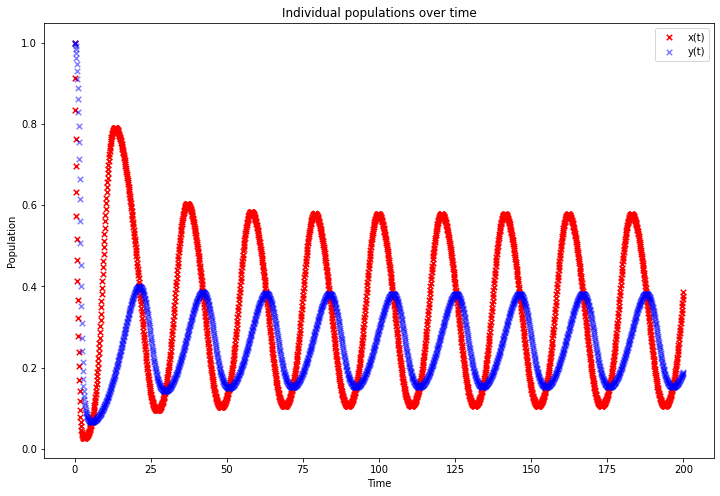

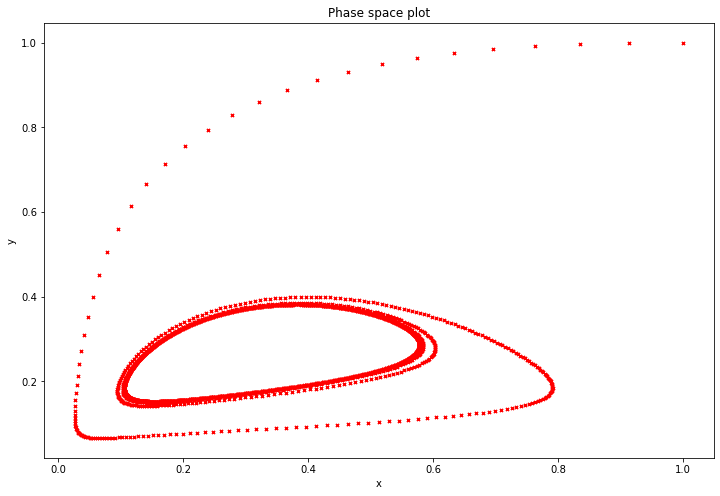

In [2]:
# Define ODE function f(x,t)
def predator_prey(x: np.ndarray, t: float):
    '''
    Defines RHS for Predator Prey system
    '''
    # Define constants inside function for now
    a = 1
    d = 0.1
    b = 0.2

    dxdt = x[0]*(1-x[0]) - (a*x[0]*x[1])/(d+x[0])
    dydt = b*x[1]*(1-(x[1]/x[0]))
    return np.array((dxdt, dydt))

# Calling solve_to with RK4 method
x_init = np.array((1,1))
solution = solve_to(predator_prey, x_init, 0, 200, 0.1, 'RK4')

plt.figure(figsize=[12,8])
plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
plt.legend()
plt.title("Individual populations over time")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
plt.title("Phase space plot")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

For b < 0.26 the solution converges to a stable limit cycle
For b > 0.26 the solution converges to a stable equillibrium point

We fix b = 0.20 and try to ascertain the period. We look at t>100 (halfway) when it has settled. Take the value of x,y at t=100, and look for the next time it reaches near this by some threshhold. Since this is an ODE we don't bother to take an average across multiple oscillations for period

We vary the tolerance `tol` until we see a jump in the reported period. For large `tol` this will just report the next step since it's sufficiently close, so make `tol` small enough that only the next value when it exactly matches up again works.

In [3]:
# Values at 1000th step of t
fixtime, xfix, yfix = solution[1000,:]
doneflag = 1
i = 1
tol =0.001
while doneflag:
    timeval, xval, yval = solution[1000+i,:]
    if np.sqrt((xval - xfix)**2 + (yval - yfix)**2) < tol:
        doneflag = 0
        continue
    i +=1
print(timeval)
print("Period is ", round(timeval - fixtime, 2), "seconds")
print("Starting conditions: \n Start time =", fixtime,
      "\n x =", xfix,"\n y =", yfix, "\n b = 0.2")


120.80000000000001
Period is  20.8 seconds
Starting conditions: 
 Start time = 100.0 
 x = 0.577460690300921 
 y = 0.29367636154151294 
 b = 0.2


--------
**Finding limit cycles**
We found the (almost) converged limit cycle above, but we want a way to probe the ODE function to look for existing limit cycles independent of starting condition.

A perfect periodic orbit would have the property `u0 = u(init=u0, T)`, where init are intial conditions shared by both, and T is the unknown period. So we look for a pair (u0, T) where this happens, by finding the root of function `G(u0,T) = [u0 - u(init=0,T)]`.

Here u(init=0,T) is given by our solver by finding the solution from u0 onwards and accessing the value at time t=T

Problem: there's an infinite family of solutions paramaterised by the start time / phase. We fix the phase by also requiring a 'phase condition' phi that arbitrarily fixes the phase.

---

Constant phase condition: 

Write `u(init, t)= [x , y]`. Then fix `x(t)=a` , for some `a`. This fixes one variable in place, but note if we chose an `a` that lives outside the range of x values in the limit cycle then this requirement stops us from finding a limit cycle. So constant phase condition isn't the best

Setting `phi(u0)= x(0) - a` we then just need to find the root of the stacked vector equation `[G, phi](u0)`

---

Derivative phase condition:

If we have a limit cycle, then the x(t) component is guaranteed to reach a turning point with dx/dt=0, since it needs to turn around at some point to attain its starting value that it deviates from, and we assume x is continuous. So just instead set `phi(u0) = dx/dt[0]`. Note that for second order ODEs converted into first order, we might have state variables [x, dx/dt] meaning we can simply search for the second state variable being 0, whereas for ODEs with state variables like [x, y] we access the derivative dx/dt from the ODE statement.

---

So to find a limit cycle we want to find a cycle starting on init condition u0=[x0, y0], with period T, where dx/dt[0] = 0.

We do this by finding a root [u0, T] to [G(u0,T), phi(u0)]: a n+1 dimensional vector valued function. We have to investigate optimisation algorithms that will search the space of parameters [u0, T] and locate a route. We might make the assumption that the functions G, phi will be smooth with respect to these parameters, so that gradient based methods can work. 

False
[ 0.65204     0.29277565 20.63646509]


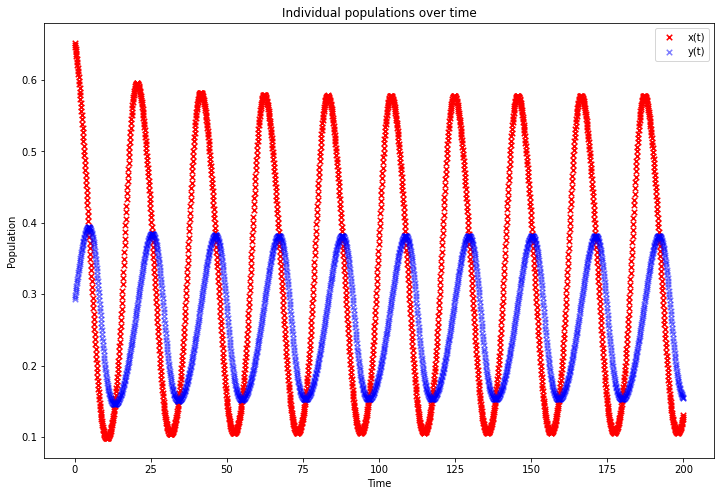

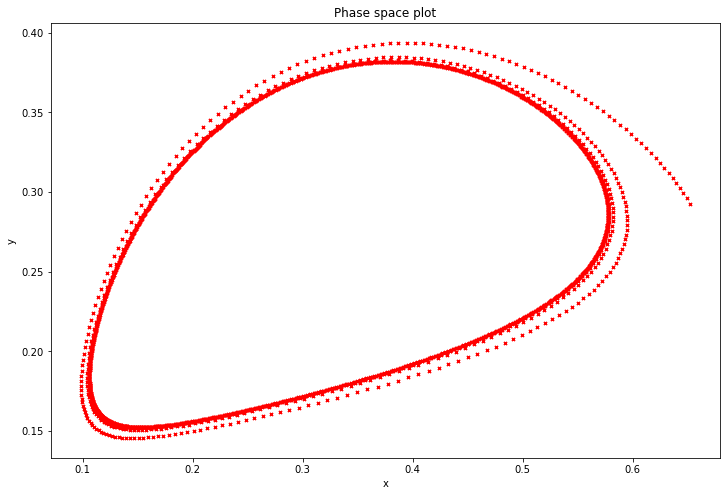

In [4]:
# We define the G,phi function to extract the root from

def limit_cycle_condition(params: np.ndarray, 
                          phase_condition: Literal['constant', 'derivative']='derivative',
                          constant_value: float = None):
    ''' 
    Defines the function [G(u0,T),phi(u0)] specified above
    '''
    if phase_condition == 'constant' and constant_value == None:
        raise Exception("Error: Please supply a starting value that the first state variable must attain")
        # TODO: make this message more clear

    # Extract u0, T
    u0, T = params[0:2], params[2]

    # Compute G by calling the solver to solve until time T
    solution = solve_to(f=predator_prey, x_init=u0, t_init=0, 
                        t_final=T, deltat_max=0.1, method='RK4')
    uT = solution[-1,1:]
    G = u0 - uT
    
    if phase_condition == 'constant':
        phi = u0[0] - constant_value
    elif phase_condition == 'derivative':
        # Compute phi by calling the ODE function at time 0 with u0
        u0dot = predator_prey(u0, 0)
        phi = u0dot[0]

    # TODO: generalise this to take any function def
    return np.append(G,[phi])

# TODO: compare root finding
# Scipi optimise root finding uses 'modification of Powell hybrid method' 
# Returns OptimizeResult object with attributes

result = root(limit_cycle_condition, np.array([0.6,0.2,20]), args=('constant', 0.7))
result.keys()
# Check if successful
print(result.success)
best_params = result.x
print(best_params)

# Verify against periodic orbit found

x_init = best_params[0:2]
solution = solve_to(predator_prey, x_init, 0, 200, 0.1, 'RK4')

plt.figure(figsize=[12,8])
plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
plt.legend()
plt.title("Individual populations over time")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
plt.title("Phase space plot")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


When we set initial parameter guesses to x=0.6, y=0.2, T=20, scipy root finds the stable orbit, which is validated when we integrate then plot starting from this orbit.

If you were to set the guesses to x=1,y=1,T=1 you find a solution that starts on a tiny orbit which then diverges (possibly due to numerical error)

---------

We now seek to generalise this method, to find any limit cycle given a function, its parameters and an initial guess for the period of the cycle and a phase condition.

-First start by generalising the limit_cycle_condition function to work with any ODE function

In [5]:
def limit_cycle_condition(ode_func,
                          params: np.ndarray, 
                          phase_condition: Literal['constant', 'derivative']='derivative',
                          constant_value: float = None,
                          deltat_max: float = 0.1):
    ''' 
    Computes the pair [ G(u0, T), phi(u0) ] which we later find the root of with scipy, to search for limit cycles.
    A limit cycle will have [T, u0] such that this function returns zeros.

    ------------------------------------------------------------------------------------------------------------
    INPUTS
    ode_func: Definition function for the RHS of the ODE

    params: 1-D Numpy array in format [T, u0]. Here T (float) is the period of the limit cycle, and u0
    (array of floats) is the initial point along the limit cycle

    phase_condition: String, either be 'constant' or 'derivative' for methods specified below

    constant_value: Float value that the first state variable should start from. Must be supplied
    if phase_condition == 'constant'

    deltat_max: Float value step size used by solve_to solver to compute the solution after time T

    RETURNS
    1-D Numpy array [G, phi] where the length of G is the number of state variables in the 
    ODE function, phi is a single float.
    
    -------------------------------------------------------------------------------------------------------------
    METHOD
    G is the element-wise difference between our starting point u0 and the end of its trajectory
    after time T, uT. When G is zero this means the solution has returned to its starting point
    u0 after time T, and our solution is thus periodic.

    phi is the phase condition, used to set the phase and thus choose a periodic orbit from the
    family of orbits generated when G=0. 

    If phase_condition == 'constant' then we supply a 'constant_value', which the first state
    variable of the ODE must attain at time t=0. We set phi = constant_value - u0[0]

    If phase_condition == 'derivative' then we compute the derivative of the first state 
    variable at time t=0. Every limit cycle should contain a point where the first state variable
    has a turning point (or is constant). We set phi = d/dt[u[t=0]]
    '''
    if phase_condition == 'constant' and constant_value == None:
        raise Exception("Error: Please supply a starting value that the first state variable must attain")

    # Extract T, u0 from params
    T, u0 = params[0], params[1:]

    # Compute G by calling the solver to solve until time T. Solve with RK4 and deltat_max supplied
    solution = solve_to(f=ode_func, x_init=u0, t_init=0, 
                        t_final=T, deltat_max=deltat_max, method='RK4')
    uT = solution[-1,1:]
    G = u0 - uT
    
    # Compute phi 
    if phase_condition == 'constant':
        # Compute difference between first state variable at time t=0 and constant_value
        phi = u0[0] - constant_value
    elif phase_condition == 'derivative':
        # Compute derivative of first state variable at time t=0
        u0dot = ode_func(u0, 0)
        phi = u0dot[0]

    return np.append(G,[phi])

False
[20.6364652   0.65203998  0.29277562]


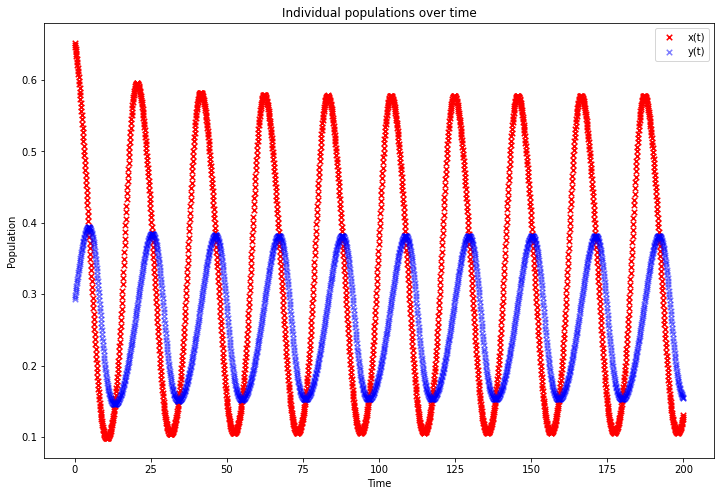

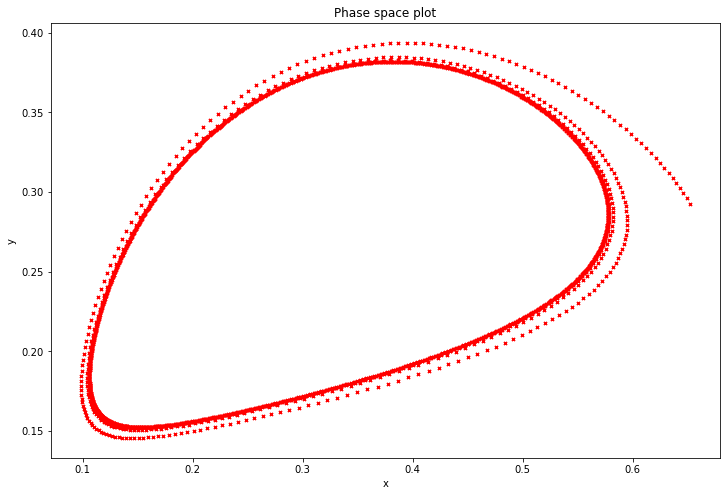

In [6]:
# Unit test this function with same predator_prey ODE as before:

# Establish lambda function to set params before passing to result
predator_prey_limit_cycle = lambda params: limit_cycle_condition(ode_func=predator_prey,
                                                                 params=params,
                                                                 phase_condition='constant',
                                                                 constant_value=0.7,
                                                                 deltat_max=0.1)

result = root(predator_prey_limit_cycle, np.array([20, 0.6,0.2]))
result.keys()
# Check if successful
print(result.success)
best_params = result.x
print(best_params)

# Verify against periodic orbit found

x_init = best_params[1:]
solution = solve_to(predator_prey, x_init, 0, 200, 0.1, 'RK4')

plt.figure(figsize=[12,8])
plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
plt.legend()
plt.title("Individual populations over time")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
plt.title("Phase space plot")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


----------
Generalising into a function:
-We want to supply an ODE function, phase condition type (with constant_value if needed), initial guess array, option to print found limit cycle, option to plot limit cycle with final time (IF 2D), return the initial conditions of the limit cycle as an array, print whether root finding limit cycle was succesful
-need to import scipy optimise within function?

In [7]:
def find_limit_cycle(ode_func, 
                     init_point_guess: np.ndarray,
                     init_period_guess: float,
                     phase_condition: Literal['constant', 'derivative']='derivative',
                     constant_value: float = None,
                     deltat_max: float = 0.1,
                     print_findings: bool = True):
    '''
    Takes in an ODE definition function, and an initial guess for the period and starting state
    of a limit cycle of that ODE. Uses scipy.optimize.root with limit_cycle_condition to converge
    towards a limit cycle starting with the supplied guess. If convergence is successful, returns
    the period and starting state of the limit cycle it located.
    --------------
    INPUTS
    ode_func: Definition function for the RHS of the ODE at position x, time t

    init_point_guess: 1-D Numpy array, initial guess for the starting state of a limit cycle

    init_period_guess: Float, initial guess for the period of the limit cycle

    phase_condition: String, either be 'constant' or 'derivative'

    constant_value: Float value that the first state variable should start from. Must be supplied
    if phase_condition == 'constant'

    deltat_max: Float value step size used by solve_to solver to compute the solution after time T

    print_findings: Boolean value, if True then this function prints out if the convergence was
    successful, and if so the period and starting state of the limit cycle

    RETURNS
    if convergence:
        best_period: float, the period of the found limit cycle
        best_point: float, the starting state of the found limit cycle
    else:
        None
    '''
    # Establish lambda function for use with scipy.optimize.root, means we only vary params
    specific_condition = lambda params: limit_cycle_condition(ode_func=ode_func,
                                                               params = params,
                                                               phase_condition=phase_condition,
                                                               constant_value=constant_value,
                                                               deltat_max=deltat_max)

    # Pack init_point_guess and init_period_guess into params
    init_params = np.concatenate(([init_period_guess], init_point_guess))

    # Use scipy.optimize.root to search for a limit cycle
    result = root(specific_condition, init_params)

    if result.success:
        best_period, best_point = result.x[0], result.x[1:]
        if print_findings:
            print("A limit cycle was found:")
            print("Period:", best_period, ",")
            print("Starting state:", best_point, ".")
        return best_period, best_point
    else:
        if print_findings:
            print("No limit cycle was found (failed to converge).")
        return None, None

In [8]:
# TODO make unit test for this
best_period, best_point = find_limit_cycle(predator_prey, np.array(([0.6,0.3])), 15, 'constant', 2, 0.01, True)
print(best_period, best_point)

No limit cycle was found (failed to converge).
None None


In [9]:
def ode_quick_plot(ode_func, init_state, t_final=200, step=0.1):
    # Just for quick testing, not rigorous
    solution = solve_to(ode_func, init_state, 0, t_final, step, 'RK4')

    plt.figure(figsize=[12,8])
    plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
    plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
    plt.legend()
    plt.title("State variables over time")
    plt.xlabel("Time")
    plt.ylabel("Variable value")
    plt.show()

    plt.figure(figsize=[12,8])
    plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
    plt.title("Phase space plot")
    plt.xlabel("Variable 1")
    plt.ylabel("Variable 2")
    plt.show()
    return None

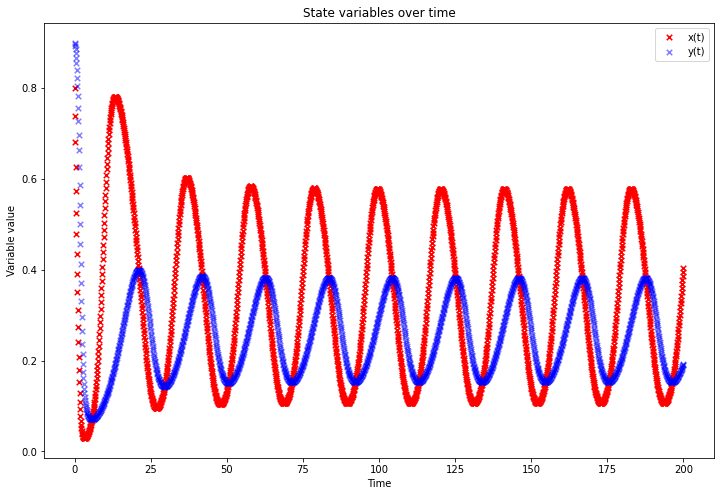

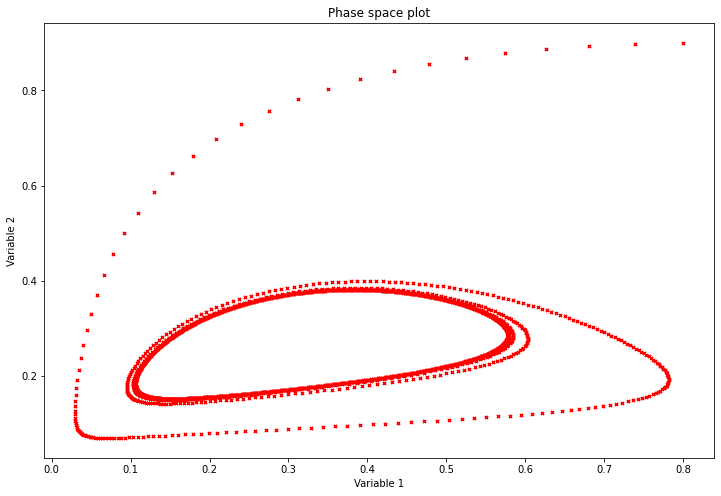

In [10]:
ode_quick_plot(predator_prey, np.array(([0.8,0.9])))

A limit cycle was found:
Period: 20.81686685617078 ,
Starting state: [0.5778715  0.28614888] .
20.81686685617078 [0.5778715  0.28614888]


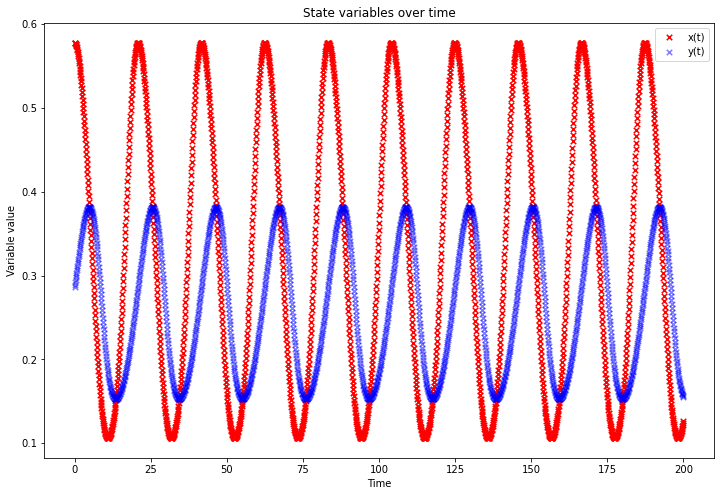

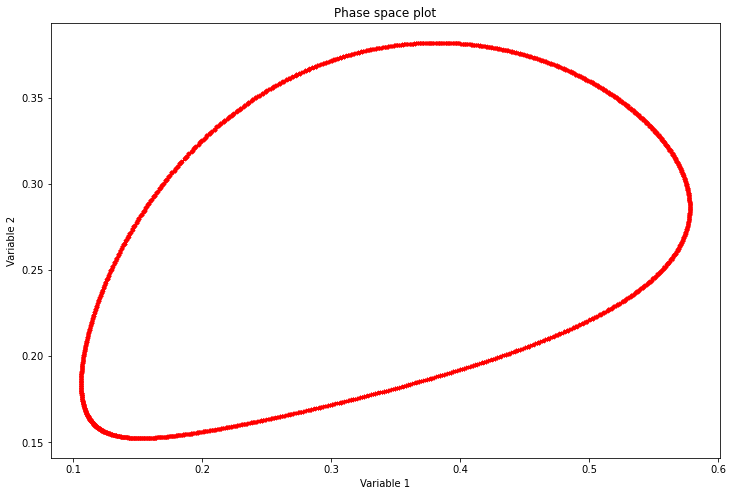

In [11]:
period, start_point = find_limit_cycle(predator_prey, np.array(([0.6,0.3])), 15)
print(period, start_point)
ode_quick_plot(predator_prey, start_point)

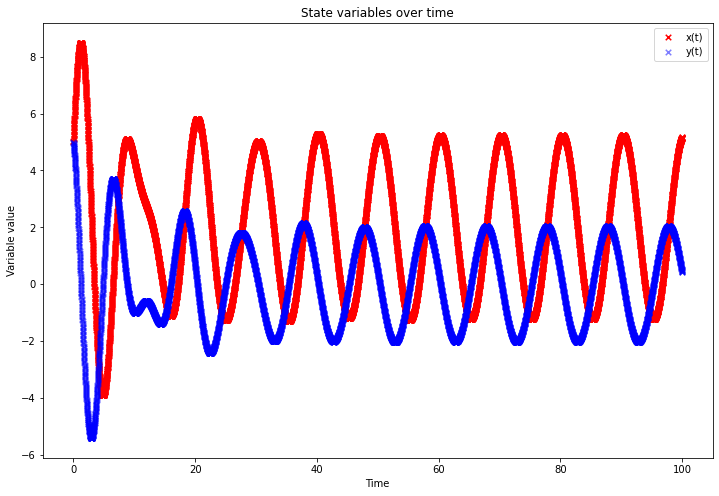

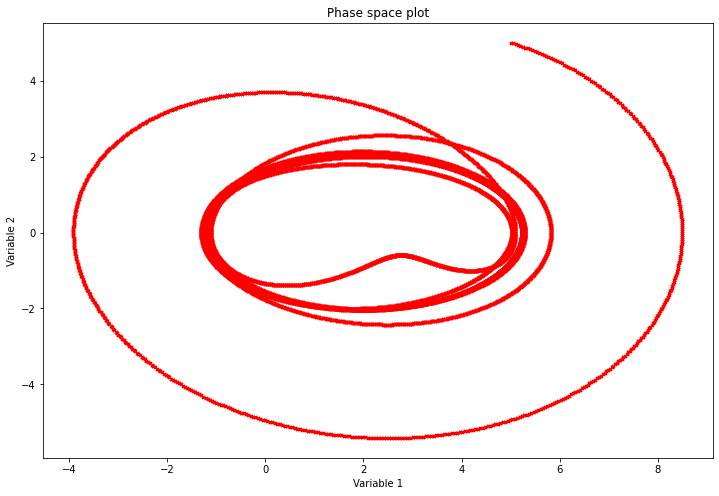

In [12]:
# Trying on SHM ode
def shm(x,t):
    damping = 0.2
    forcing_amplitude = 2
    forcing_period = 10
    s = x[0]
    v = x[1]
    a = -s  + -damping*v + forcing_amplitude*(1+ np.cos(t*(2*np.pi)/forcing_period))
    return np.array(([v,a]))

ode_quick_plot(shm, np.array(([5,5])), step=0.01, t_final=100)


A limit cycle was found:
Period: 6.19248311764963 ,
Starting state: [-7.34523504e+00 -3.00941108e-24] .


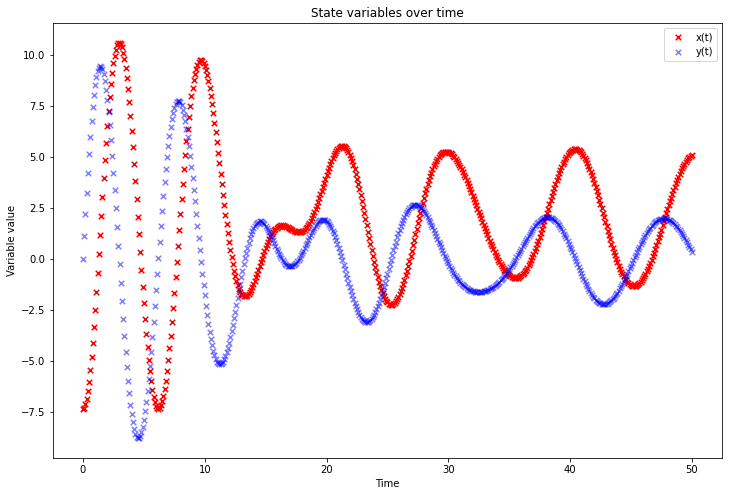

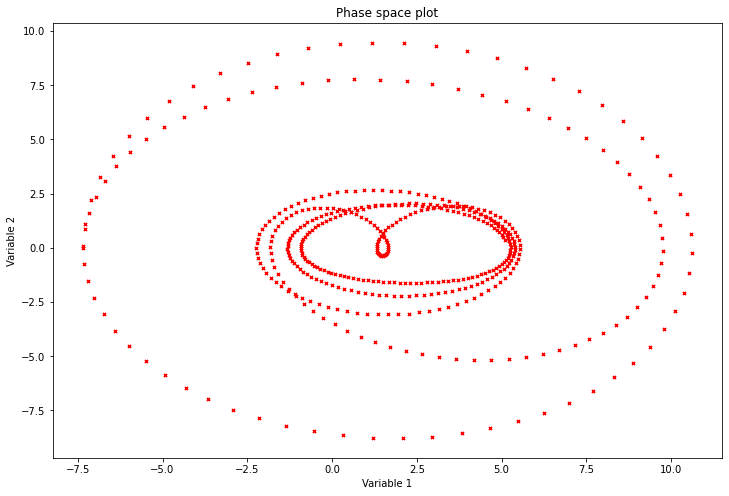

In [13]:
period, start_point = find_limit_cycle(shm, np.array(([2,1])), 5)
ode_quick_plot(shm, start_point, t_final=50)

Testing this on the forced damped simple harmonic oscillator we see that our code fails to identify limit cycles - it instead finds a cycle that does repeat after time T, but we see after plotting it that the solution then converges to an oval, away from the starting state. This suggests that our code might fail on other non-autonomous systems. 

We should modify the code to check the value after a few loops. We thus redefine `limit_cycle_condition`

In [14]:
def limit_cycle_condition(ode_func,
                          params: np.ndarray, 
                          num_loops_needed: float = 10,
                          phase_condition: Literal['constant', 'derivative']='derivative',
                          constant_value: float = None,
                          deltat_max: float = 0.1):
    ''' 
    Computes the pair [ G(u0, T), phi(u0) ] which we later find the root of with scipy, to search for limit cycles.
    A limit cycle will have [T, u0] such that this function returns zeros.

    ------------------------------------------------------------------------------------------------------------
    INPUTS
    ode_func: Definition function for the RHS of the ODE

    params: 1-D Numpy array in format [T, u0]. Here T (float) is the period of the limit cycle, and u0
    (array of floats) is the initial point along the limit cycle

    num_loops_needed: Float, determines how many successive loops are checked

    phase_condition: String, either be 'constant' or 'derivative' for methods specified below

    constant_value: Float value that the first state variable should start from. Must be supplied
    if phase_condition == 'constant'

    deltat_max: Float value step size used by solve_to solver to compute the solution after time T

    RETURNS
    1-D Numpy array [G, phi] where the length of G is the number of state variables in the 
    ODE function, phi is a single float.
    
    -------------------------------------------------------------------------------------------------------------
    METHOD
    G is the element-wise difference between our starting point u0 and the end of its trajectory
    after time T, uT. When G is zero this means the solution has returned to its starting point
    u0 after time T, and our solution is thus periodic.

    phi is the phase condition, used to set the phase and thus choose a periodic orbit from the
    family of orbits generated when G=0. 

    If phase_condition == 'constant' then we supply a 'constant_value', which the first state
    variable of the ODE must attain at time t=0. We set phi = constant_value - u0[0]

    If phase_condition == 'derivative' then we compute the derivative of the first state 
    variable at time t=0. Every limit cycle should contain a point where the first state variable
    has a turning point (or is constant). We set phi = d/dt[u[t=0]]
    '''
    if phase_condition == 'constant' and constant_value == None:
        raise Exception("Error: Please supply a starting value that the first state variable must attain")

    # Extract T, u0 from params
    T, u0 = params[0], params[1:]

    # Establish empty array to hold Gs
    num_variables = len(u0)
    G_collection = np.zeros([num_loops_needed*num_variables])

    # Loop over number of loops checked
    for i in range(num_loops_needed):
        # Compute G by calling the solver to solve until time (i+1)*T. Solve with RK4 and deltat_max supplied
        solution = solve_to(f=ode_func, x_init=u0, t_init=0, 
                            t_final=(i+1)*T, deltat_max=deltat_max, method='RK4')
        uT = solution[-1,1:]
        G = u0 - uT
        G_collection[i*num_variables:(i+1)*num_variables] = G
    
    # Compute phi 
    if phase_condition == 'constant':
        # Compute difference between first state variable at time t=0 and constant_value
        phi = u0[0] - constant_value
    elif phase_condition == 'derivative':
        # Compute derivative of first state variable at time t=0
        u0dot = ode_func(u0, 0)
        phi = u0dot[0]

    return np.append(G_collection,[phi])

In [15]:
limit_cycle_condition(predator_prey,np.array(([20,0.3,0.3])))

array([-0.0412716 , -0.02081979, -0.10780592, -0.04031393, -0.17975451,
       -0.04415116, -0.23294626, -0.03153954, -0.26401125, -0.01104925,
       -0.27616872,  0.01202444, -0.27000768,  0.03544541, -0.24448017,
        0.05807939, -0.19956418,  0.0791789 , -0.13857029,  0.09818307,
       -0.015     ])

In [22]:
def find_limit_cycle(ode_func, 
                     init_point_guess: np.ndarray,
                     init_period_guess: float,
                     num_loops_needed: int = 1,
                     phase_condition: Literal['constant', 'derivative']='derivative',
                     constant_value: float = None,
                     deltat_max: float = 0.1,
                     print_findings: bool = True):
    '''
    Takes in an ODE definition function, and an initial guess for the period and starting state
    of a limit cycle of that ODE. Uses scipy.optimize.root with limit_cycle_condition to converge
    towards a limit cycle starting with the supplied guess. If convergence is successful, returns
    the period and starting state of the limit cycle it located.
    --------------
    INPUTS
    ode_func: Definition function for the RHS of the ODE at position x, time t

    init_point_guess: 1-D Numpy array, initial guess for the starting state of a limit cycle

    init_period_guess: Float, initial guess for the period of the limit cycle

    phase_condition: String, either be 'constant' or 'derivative'

    constant_value: Float value that the first state variable should start from. Must be supplied
    if phase_condition == 'constant'

    deltat_max: Float value step size used by solve_to solver to compute the solution after time T

    print_findings: Boolean value, if True then this function prints out if the convergence was
    successful, and if so the period and starting state of the limit cycle

    RETURNS
    if convergence:
        best_period: float, the period of the found limit cycle
        best_point: float, the starting state of the found limit cycle
    else:
        None
    '''
    # Establish lambda function for use with scipy.optimize.root, means we only vary params
    specific_condition = lambda params: limit_cycle_condition(ode_func=ode_func,
                                                              num_loops_needed=num_loops_needed,
                                                              params = params,
                                                              phase_condition=phase_condition,
                                                              constant_value=constant_value,
                                                              deltat_max=deltat_max)


    # Pack init_point_guess and init_period_guess into params
    init_params = np.concatenate(([init_period_guess], init_point_guess))

    print(init_params)
    print(specific_condition(init_params))
    # Use scipy.optimize.root to search for a limit cycle
    if num_loops_needed == 1:
        result = root(specific_condition, init_params)
    else: 
        # Have to change method since default 'hybr' requires input and output sizes of 
        # 'specific condition' to be the same.
        result = root(specific_condition, init_params, method='lm')

    if result.success:
        best_period, best_point = result.x[0], result.x[1:]
        if print_findings:
            print("A limit cycle was found:")
            print("Period:", best_period, ",")
            print("Starting state:", best_point, ".")
        return best_period, best_point
    else:
        if print_findings:
            print("No limit cycle was found (failed to converge).")
        return None, None

[15.   0.6  0.3]
[ 0.33762464  0.13712659 -0.01714286]
A limit cycle was found:
Period: 20.81686685617078 ,
Starting state: [0.5778715  0.28614888] .


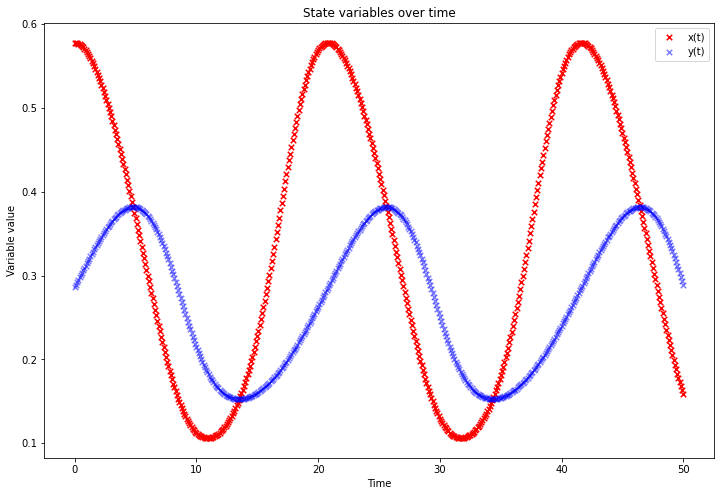

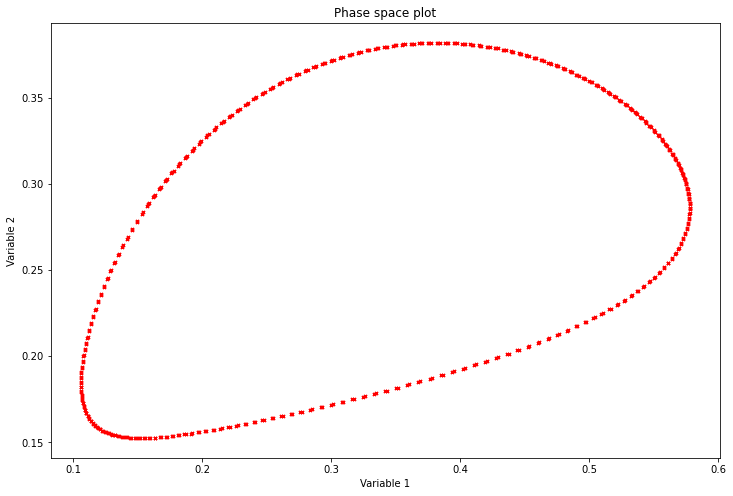

In [31]:
best_period, best_point = find_limit_cycle(ode_func = predator_prey,
                                           init_point_guess = np.array(([0.6,0.3])),
                                           init_period_guess= 15,
                                           num_loops_needed = 1)
ode_quick_plot(predator_prey, best_point, t_final=50)